In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-05-23 15:08:04--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-05-23 15:08:04--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  22.2MB/s    in 36s     

2022-05-23 15:08:41 (20.8 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-05-23 15:08:42--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Co

In [4]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

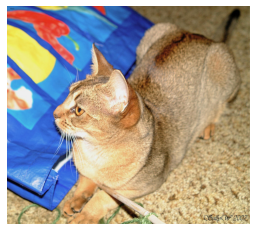

In [6]:
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

In the normalized_array, subtracted by 1 to make labels range from 0 to 2 (original labels are 1 to 3)
<br>
Multiplied by 127 so that the labels range from black (0) to gray (127) and near-white (254)

In [7]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127 
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

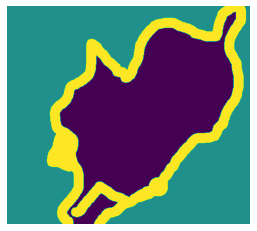

In [8]:
img = img_to_array(load_img(target_paths[9], color_mode="grayscale")) 
display_target(img)

In [9]:
img_size = (200, 200) 
num_imgs = len(input_img_paths)

In [10]:
random.Random(1337).shuffle(input_img_paths) 
random.Random(1337).shuffle(target_paths)

In [11]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

In [12]:
def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1 # subtract by 1 so that labels are 0,1,2
    return img

In [13]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32") 
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8") 
for i in range(num_imgs): 
    input_imgs[i] = path_to_input_image(input_img_paths[i]) 
    targets[i] = path_to_target(target_paths[i])

In [14]:
num_val_samples = 1000 
train_input_imgs = input_imgs[:-num_val_samples] 
train_targets = targets[:-num_val_samples] 
val_input_imgs = input_imgs[-num_val_samples:] 
val_targets = targets[-num_val_samples:]

In [15]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,)) # (3,) adds 3 channel rgb
    x = layers.Rescaling(1./255)(inputs) # rescale image from range [0, 255] to [0, 1]
    
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x) # use stride=2 to downsample image  by a factor of 2
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x) 
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x) # upscale image by a factor of 2 (strides=2)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x) 
    
    model = keras.Model(inputs, outputs)
    
    return model

In [16]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168

2022-05-23 15:09:42.139231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 15:09:42.272310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 15:09:42.273026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 15:09:42.274103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [18]:
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",save_best_only=True)]

In [19]:
history = model.fit(
    train_input_imgs, 
    train_targets,
    epochs=50,
    callbacks=callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets)
)

2022-05-23 15:09:45.025229: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3067200000 exceeds 10% of free system memory.
2022-05-23 15:09:48.258638: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 255600000 exceeds 10% of free system memory.
2022-05-23 15:09:48.555112: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3067200000 exceeds 10% of free system memory.
2022-05-23 15:09:50.722144: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 255600000 exceeds 10% of free system memory.
2022-05-23 15:09:50.942627: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-23 15:09:52.997369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - ETA: 0s - loss: 1.4429

2022-05-23 15:10:35.113970: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 480000000 exceeds 10% of free system memory.


100/100 [==============================] - 48s 375ms/step - loss: 1.4429 - val_loss: 0.9584
Epoch 2/50
100/100 [==============================] - 33s 332ms/step - loss: 0.9001 - val_loss: 0.8543
Epoch 3/50
100/100 [==============================] - 33s 333ms/step - loss: 0.8116 - val_loss: 0.7606
Epoch 4/50
100/100 [==============================] - 33s 333ms/step - loss: 0.8047 - val_loss: 0.7120
Epoch 5/50
100/100 [==============================] - 33s 332ms/step - loss: 0.7136 - val_loss: 0.9365
Epoch 6/50
100/100 [==============================] - 33s 332ms/step - loss: 0.6791 - val_loss: 0.6559
Epoch 7/50
100/100 [==============================] - 33s 332ms/step - loss: 0.6324 - val_loss: 0.6216
Epoch 8/50
100/100 [==============================] - 33s 332ms/step - loss: 0.5885 - val_loss: 0.5301
Epoch 9/50
100/100 [==============================] - 33s 332ms/step - loss: 0.5776 - val_loss: 0.5508
Epoch 10/50
100/100 [==============================] - 33s 332ms/step - loss: 0.5503

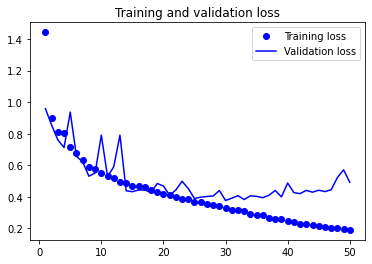

In [20]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [22]:
model = keras.models.load_model("oxford_segmentation.keras") # load previously saved best model from callbacks

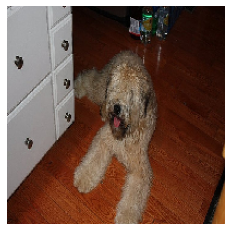

In [26]:
test_image = val_input_imgs[13]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

In [24]:
def display_mask(pred): 
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

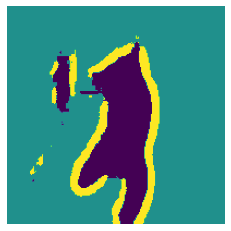

In [27]:
display_mask(mask)